In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import healpy as hp
import time
import warnings
import scipy.fftpack

In [4]:
#Gabor filter

def gabor_1d( N, sigma, freq):
    """
        Computes a symmetric 2D Gabor filter.
        ----------
        M, N : int
            spatial sizes
        sigma : float
            bandwidth parameter
        freq : float
            central frequency (in [0, pi])
        theta : float
            angle in [0, pi]
        offset : int, optional
            offset by which the signal starts
        Returns
        -------
        gabor_2d : ndarray
            numpy array of size (M, N)
    """
    gab = np.zeros( N, np.complex64)
    #[x, y] = np.mgrid[-1*(M//2):(M//2),-1*(N//2):(N//2)]
    
    x = np.arange (-1*N//2,N//2)

    arg = -(x**2)/(2*sigma*sigma) + 1.j * freq*np.sqrt(x**2)
    #print (arg.shape)
    gab += np.exp(arg)

    norm_factor = (2 * np.pi * sigma * sigma)
    #gab /= norm_factor

    return gab

In [8]:
def morlet_1d( N, sigma, freq):
    """
        Computes a symmetric 2D Morlet filter.
        A Morlet filter is the sum of a Gabor filter and a low-pass filter
        to ensure that the sum has exactly zero mean in the temporal domain.
        It is defined by the following formula in space:
        psi(u) = g_{sigma}(u) (e^(i xi^T u) - beta)
        where g_{sigma} is a Gaussian envelope, xi is a frequency and beta is
        the cancelling parameter.
        Parameters
        ----------
        M, N : int
            spatial sizes
        sigma : float
            bandwidth parameter
        xi : float
            central frequency (in [0, pi])
        theta : float
            angle in [0, pi]
        Returns
        -------
        morlet_2d : ndarray
            numpy array of size (M, N)
    """
    wv = gabor_1d( N, sigma,  freq)
    wv_modulus = gabor_1d( N, sigma, 0)
    K = np.sum(wv) / np.sum(wv_modulus)

    mor = wv - K * wv_modulus
    mor = mor / np.sqrt(np.sum (np.abs(mor)**2))
    return mor

In [166]:
def comp_s1(image, morlet_arr, jmax, gaus_arr = None):
    
    s1_arr = np.zeros (jmax)
    i1_arr = []
    for j1 in range(jmax):
        
        #sigma1=0.8*2**j1
        #freq1=(3*np.pi)/(4.*2**j1)
        
        #mor1=morlet_2d(M, N, sigma1, freq1)
        #phi1=gabor_2d(M,N,sigma1,0)
        
        mor = morlet_arr[j1]
        mor_fft=np.real(np.fft.fft2(np.fft.fftshift(mor)))
        
        img_fft = np.fft.fft2(image)
        I1_fft = img_fft * mor_fft
        I1 = np.abs (np.fft.ifft2(I1_fft))
        
        
        if gaus_arr == None:
            S1 = I1
        else:
            phi = gaus_arr[j1]
            phi_fft = np.real(np.fft.fft2(np.fft.fftshift(phi)))
            U1_fft = np.fft.fft2(I1)
            S1_fft = U1*phi_fft
            S1 = np.real(np.fft.ifft2(S1_fft))
        
        i1_arr.append(S1)
        s1_arr[j1] = np.mean(S1)
    
    return s1_arr , i1_arr

In [167]:
def comp_s2 (i1_arr, morlet_arr, jmax, gaus_arr = None ):
    
    s2_arr = np.zeros ((jmax,jmax))
    i2_arr = []
    for j1 in range(jmax):
        i2_tmp = []
        i1 = i1_arr[j1]
        i1_fft = np.fft.fft2(i1)
        
        for j2 in range (jmax):
        
            mor = morlet_arr[j2]
            mor_fft=np.real(np.fft.fft2(np.fft.fftshift(mor)))

            
            I2_fft = i1_fft * mor_fft
            I2 = np.abs (np.fft.ifft2(I2_fft))


            if gaus_arr == None:
                S2 = I2
            else:
                phi = gaus_arr[j2]
                phi_fft = np.real(np.fft.fft2(np.fft.fftshift(phi)))
                U2_fft = np.fft.fft2(I2)
                S2_fft = I2*phi_fft
                S2 = np.abs(np.fft.ifft2(S2_fft))

            s2_arr[j1,j2] = np.mean(S2)
            i2_tmp.append(S2)
        i2_arr.append (i2_tmp)
    return s2_arr , i2_arr

In [168]:
def comp_s3 (i2_arr, morlet_arr, jmax, gaus_arr = None ):
    
    s3_arr = np.zeros ((jmax,jmax,jmax))
    #i3_arr = []
    for j1 in range(jmax):
        for j2 in range (j1+1 ,jmax):
            #i3_tmp = []
            i2 = i2_arr[j1][j2]
            i2_fft = np.fft.fft2(i2)
        
            for j3 in range (jmax):
        
                mor = morlet_arr[j3]
                mor_fft=np.real(np.fft.fft2(np.fft.fftshift(mor)))


                I3_fft = i2_fft * mor_fft
                I3 = np.abs (np.fft.ifft2(I3_fft))


                if gaus_arr == None:
                    S3 = I3
                else:
                    phi = gaus_arr[j3]
                    phi_fft = np.real(np.fft.fft2(np.fft.fftshift(phi)))
                    U3_fft = np.fft.fft2(I3)
                    S3_fft = I3*phi_fft
                    S3 = np.abs(np.fft.ifft2(S3_fft))

                s3_arr[j1,j2,j3] = np.mean(S3)
                #i3_tmp.append(S2)
        #i2_arr.append (i2_tmp)
    return s3_arr #, i2_arr

In [3]:
np.arange (-1,3)

array([-1,  0,  1,  2])

In [9]:
N = 1000
jmax = 10

morlet_arr = []
for j in range (jmax):
    sigma=0.8*2**j
    freq=(3*np.pi)/(4.*2**j)
    mor = morlet_1d (N, sigma, freq)
    morlet_arr.append(mor)
    

In [10]:
morlet_k_array = []
for j in range (jmax):
    mor = morlet_arr[j]
    mor_fft=np.fft.fft(np.fft.fftshift(np.real(mor)))
    morlet_k_array.append(mor_fft)



In [17]:
freq =  np.fft.fftfreq(N)
np.sum (np.real(morlet_k_array[5]**2)*freq[1])

0.7722154359213305

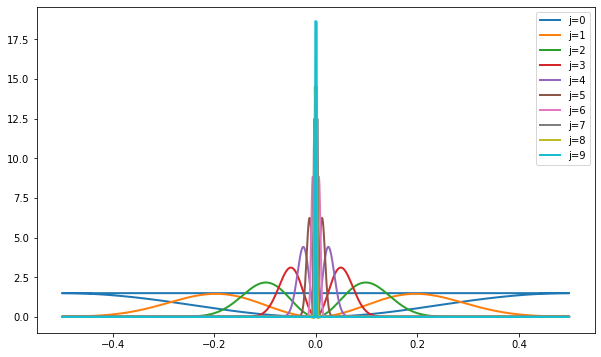

In [32]:
fig = plt.figure(figsize=[10,6])
for i in range (0,jmax):
    ax = plt.plot (freq, np.real(morlet_k_array[i]),label='j='+str(i), lw=2)
    plt.legend()
#plt.xlim (-0.01,0.45)

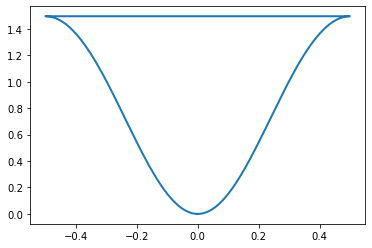

In [35]:
plt.plot (freq, np.real(morlet_k_array[0]),label='j='+str(i), lw=2)

In [40]:
np.real(morlet_k_array[0])

array([1.25627800e-07, 1.58908358e-05, 6.31857504e-05, 1.42008243e-04,
       2.52354768e-04, 3.94220360e-04, 5.67598634e-04, 7.72481791e-04,
       1.00886061e-03, 1.27672446e-03, 1.57606128e-03, 1.90685760e-03,
       2.26909855e-03, 2.66276782e-03, 3.08784769e-03, 3.54431905e-03,
       4.03216136e-03, 4.55135266e-03, 5.10186959e-03, 5.68368738e-03,
       6.29677987e-03, 6.94111945e-03, 7.61667715e-03, 8.32342256e-03,
       9.06132389e-03, 9.83034795e-03, 1.06304601e-02, 1.14616244e-02,
       1.23238035e-02, 1.32169584e-02, 1.41410492e-02, 1.50960341e-02,
       1.60818703e-02, 1.70985133e-02, 1.81459175e-02, 1.92240358e-02,
       2.03328196e-02, 2.14722190e-02, 2.26421828e-02, 2.38426585e-02,
       2.50735919e-02, 2.63349277e-02, 2.76266092e-02, 2.89485784e-02,
       3.03007756e-02, 3.16831402e-02, 3.30956100e-02, 3.45381214e-02,
       3.60106096e-02, 3.75130084e-02, 3.90452501e-02, 4.06072660e-02,
       4.21989857e-02, 4.38203377e-02, 4.54712492e-02, 4.71516458e-02,
      

In [38]:
np.where(freq==0)

(array([0]),)

In [39]:
freq

array([ 0.   ,  0.001,  0.002,  0.003,  0.004,  0.005,  0.006,  0.007,
        0.008,  0.009,  0.01 ,  0.011,  0.012,  0.013,  0.014,  0.015,
        0.016,  0.017,  0.018,  0.019,  0.02 ,  0.021,  0.022,  0.023,
        0.024,  0.025,  0.026,  0.027,  0.028,  0.029,  0.03 ,  0.031,
        0.032,  0.033,  0.034,  0.035,  0.036,  0.037,  0.038,  0.039,
        0.04 ,  0.041,  0.042,  0.043,  0.044,  0.045,  0.046,  0.047,
        0.048,  0.049,  0.05 ,  0.051,  0.052,  0.053,  0.054,  0.055,
        0.056,  0.057,  0.058,  0.059,  0.06 ,  0.061,  0.062,  0.063,
        0.064,  0.065,  0.066,  0.067,  0.068,  0.069,  0.07 ,  0.071,
        0.072,  0.073,  0.074,  0.075,  0.076,  0.077,  0.078,  0.079,
        0.08 ,  0.081,  0.082,  0.083,  0.084,  0.085,  0.086,  0.087,
        0.088,  0.089,  0.09 ,  0.091,  0.092,  0.093,  0.094,  0.095,
        0.096,  0.097,  0.098,  0.099,  0.1  ,  0.101,  0.102,  0.103,
        0.104,  0.105,  0.106,  0.107,  0.108,  0.109,  0.11 ,  0.111,
      